In [63]:
import numpy as np
import scipy
import scipy.io
import scipy.linalg
import pandas as pd
from sklearn.preprocessing import StandardScaler
from datetime import datetime 

import importlib
import knn

import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
matplotlib.rc('text.latex', preamble=r'\usepackage{bm}')

In [2]:
knn = importlib.reload(knn)

In [3]:
def CCM(ts, L, t, n_neighbors):
    H = knn.HankelMatrix(ts, L)
    svd_data = knn.Svd(H, verbose=False)
    knn_idx = knn.FindKnnIdx(H, t=t, n_neighbors=n_neighbors)
    Pr = knn.Projection(*svd_data)
    return knn_idx, Pr

### Фазовые траектории для искусственных рядов

In [3]:
N = 4000
N = 4000

t_max = 400

x_ampl = 2
x_shift = 0.3

y_scale = 2
y_shift = 0.5

np.random.seed(42)
x = np.sin(np.linspace(0, t_max, N + 1)) + 2 * np.sin(np.linspace(0, t_max, N + 1) / 2) * 0.4 + \
    np.random.randn(N + 1) * 0.3
y = np.sin(np.linspace(0, t_max, N + 1) * y_scale + y_shift) + np.random.randn(N + 1) * 0.25

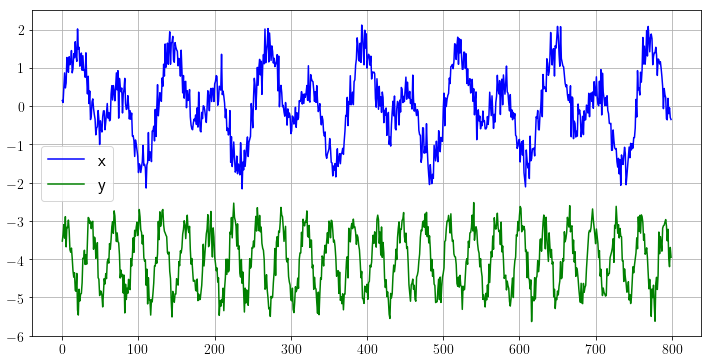

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(x[:N // 5], label='x', color='blue')
plt.plot(y[:N // 5] - 4, label='y', color='green')

plt.grid()
plt.legend(fontsize=18)
plt.xticks(size=14)
plt.yticks(size=14)

# plt.savefig('../slides/pictures/generated_data/init_ts.eps')

plt.show()

In [54]:
X_knn_idx, Pr_x = CCM(x, L=100, t=15, n_neighbors=24)
Y_knn_idx, Pr_y = CCM(y, L=100, t=20, n_neighbors=24)

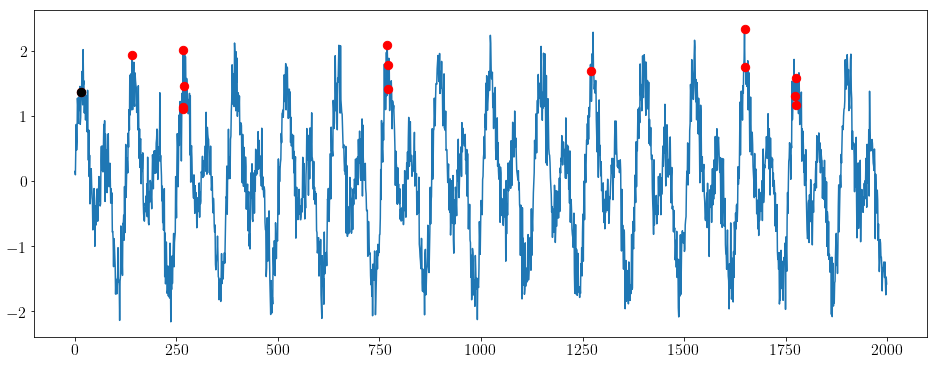

In [55]:
knn.PlotTsWithKnn(x, X_knn_idx, t_max=2000, 
              savefig=False, filename='../slides/pictures/generated_data/X_sin_knn.eps')

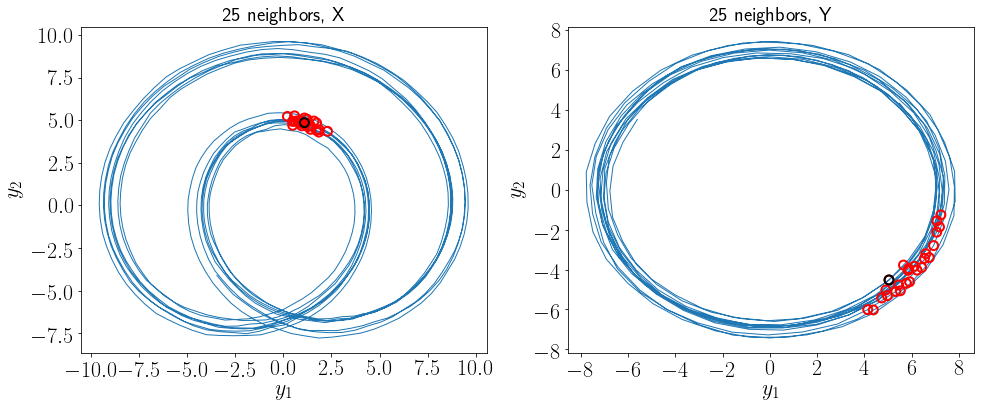

In [56]:
knn.PlotKnnOnPhaseTrajectories([(Pr_x, X_knn_idx, 'X', [0, 1], [0, 1000]), 
                                (Pr_y, X_knn_idx, 'Y', [0, 1], [0, 400])],
                               savefig=False, filename='../slides/pictures/generated_data/phase_tr_by_X.eps', 
                               i_list=[0, 2, 7])

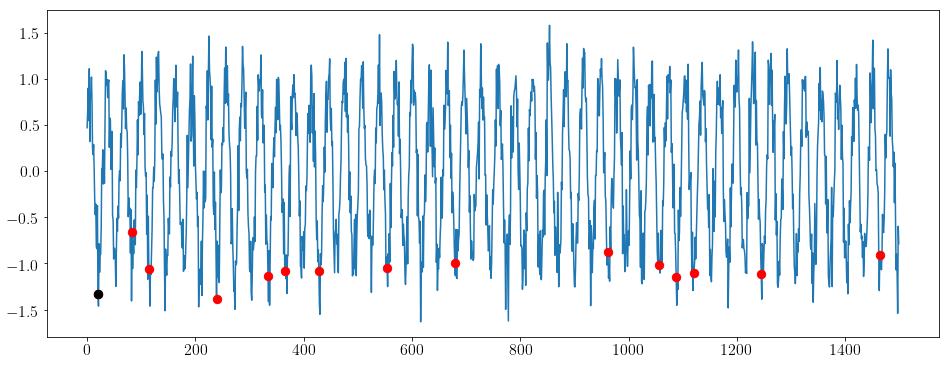

In [57]:
knn.PlotTsWithKnn(y, Y_knn_idx, t_max=1500, 
              savefig=False, filename='../slides/pictures/generated_data/Y_sin_knn.eps')

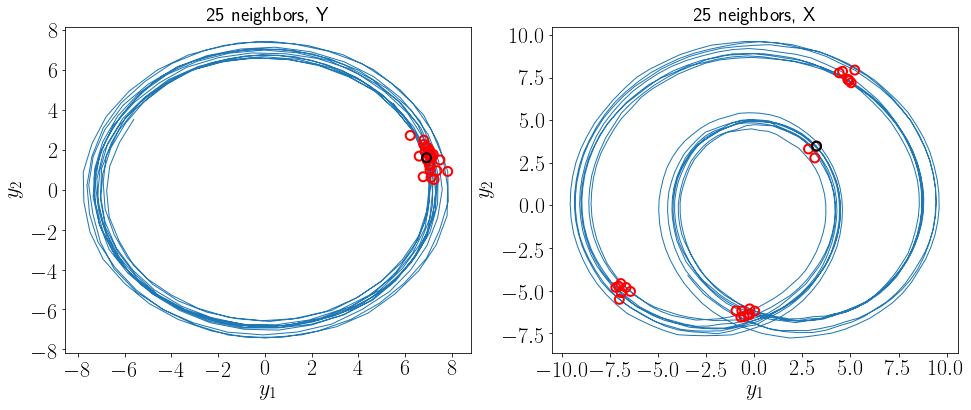

In [20]:
knn.PlotKnnOnPhaseTrajectories([(Pr_y, Y_knn_idx, 'Y', [0, 1], [0, 400]), 
                            (Pr_x, Y_knn_idx, 'X', [0, 1], [0, 1000])], 
                           savefig=False, filename='../slides/pictures/generated_data/phase_tr_by_Y.eps', 
                           i_list=[0, 1, 2, 7])

## Реальные данные

In [4]:
def MakeStationary(ts):
    new_ts = []
    for i in range(1, len(ts)):
        new_ts.append(ts[i] - ts[i - 1])
    return new_ts

In [5]:
def crosscorr(x, y, lag=0):
    return x.corr(y.shift(lag))

In [6]:
def plot_cross_cor(values, argmax, step=100, long_line=False, xticks_dens=20,
                   xlabel=None, ylabel=None, savefig=False, filename=None, title=None, color='green'):
    cor_len = len(values)
    print("cor_len:", cor_len)

    plt.figure(figsize=(15, 7))
    plt.grid(zorder=0)
    plt.axvline(x=0, lw=1.5, color='darkblue', alpha=0.65)
    plt.axhline(y=0, lw=1.5, color='darkblue', alpha=0.65)
    
    if long_line:
        plt.axvline(x=argmax, lw=2, color=color, zorder=5)
        plt.axhline(y=values[argmax], lw=2, color=color, zorder=5)
    else:
        plt.plot([0, argmax], [values[argmax], values[argmax]], color='red', zorder=5)
        plt.plot([argmax, argmax], [0, values[argmax]], color='red', zorder=5)
        
    xticks_list = [argmax] + list(range(0, cor_len, xticks_dens * step))
    plt.xticks(xticks_list, size=16)
    plt.yticks(size=16)
    
    for x in range(argmax % step, cor_len, step):
        y = values[x]
        plt.scatter(x, y, color='b', zorder=3)
        plt.scatter(x, y, color='darkorange', zorder=4, s=3)
        plt.plot([x, x], [max(y, 0), min(y, 0)], color='darkorange', zorder=2)
        
    if xlabel is not None: 
        plt.xlabel(xlabel, fontsize=22)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=22)
    if title is not None:
        plt.title(title, fontsize=22)
    if savefig and filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        
    plt.show()

### Электроэнергия + температура

In [108]:
data = pd.read_csv('../data/EnergyConsumption.csv').iloc[:, 3:]
day_len_data = pd.read_csv('../data/day_len.csv').iloc[:, 3]

In [109]:
print(data.shape, day_len_data.shape)
data.head()

(8760, 2) (365,)


,ConsumprionMWtH,TemperatureC
0,1289.617859,-10.676569
1,1265.573853,-12.041959
2,1273.188232,-13.198006
3,1279.703979,-13.999279
4,1292.839539,-14.782819


In [110]:
def MyScale(ts):
    mean = ts.mean()
    std = ts.std()

    return (ts - mean) / std

In [111]:
Z = []

for i in range(day_len_data.shape[0]):
    length = day_len_data.iloc[i]
    
    for j in range(24):
        Z.append(length)
        
Z = np.array(Z)

mean = Z.mean()
std = Z.std()

Z = (Z - mean) / std

In [112]:
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

In [113]:
X = np.array(scaled_data[:, 0])
Y = np.array(scaled_data[:, 1])

In [114]:
left = 0
right = X.shape[0]

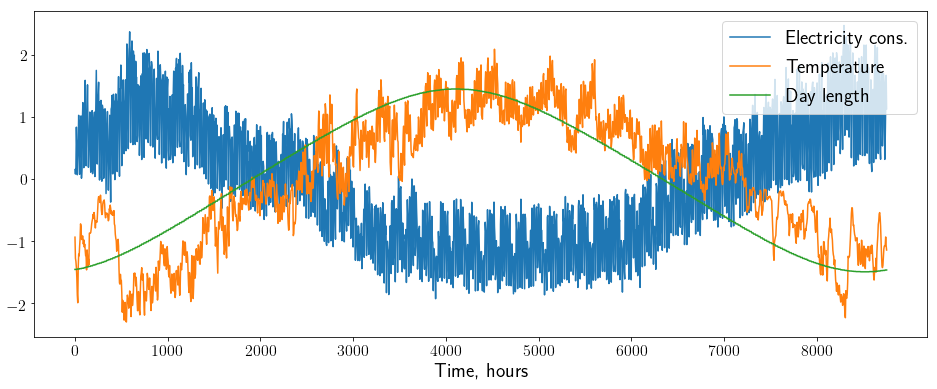

In [115]:
plt.figure(figsize=(16, 6))

plt.plot(range(0, X.shape[0], 5), X[::5], label='Electricity cons.')
plt.plot(range(0, Y.shape[0], 5), Y[::5], label='Temperature')
plt.plot(range(0, Z.shape[0], 5), Z[::5], label='Day length')

plt.xlabel('Time, hours', fontsize=20)
plt.xticks(range(0, X.shape[0], 1000), size=16)
plt.yticks(size=16)

plt.legend(loc=1, fontsize=20)
# plt.savefig('../slides/pictures/energy_temp/energy_temp_daylen_ts.eps', bbox_inches='tight')
plt.show()

In [116]:
cross_corr_list = []

for i in range(0, len(Y) - 100):
    cross_corr_list.append(crosscorr(pd.Series(Y), pd.Series(Z), i))

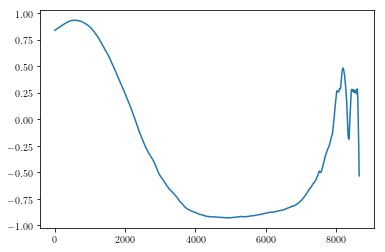

In [117]:
plt.plot(cross_corr_list)
plt.show()

In [118]:
shift = np.argmax(abs(np.array(cross_corr_list)))

cor_len: 8660


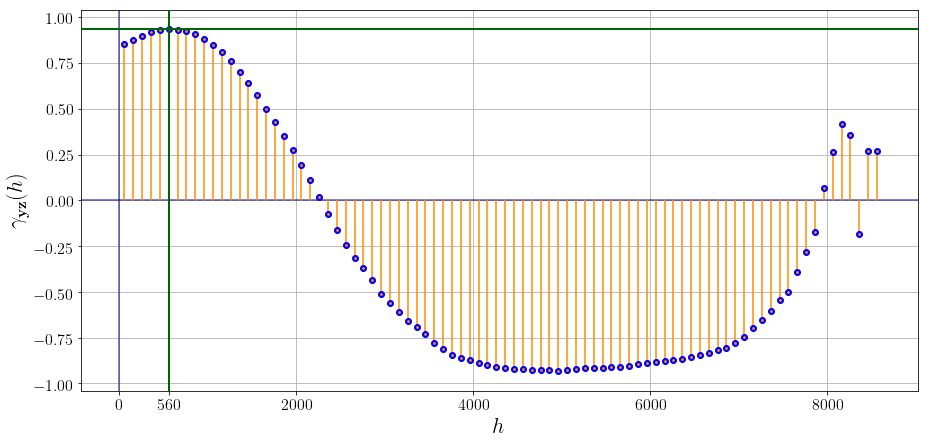

In [119]:
plot_cross_cor(cross_corr_list, shift, long_line=True,
               ylabel='$\gamma_{\mathbf{y}\mathbf{z}}(h)$', xlabel='$h$', 
              savefig=False, filename='../slides/pictures/energy_temp/cross_corr_diagram.eps', 
               color='darkgreen')

In [120]:
Y_new = []

for i in range(shift, len(Y)):
    Y_new.append(Y[i] - Z[i - shift])
    
Y_new = np.array(Y_new)
Y = Y_new

In [121]:
X = np.array(MakeStationary(X[shift:]))
Y = np.array(MakeStationary(Y))

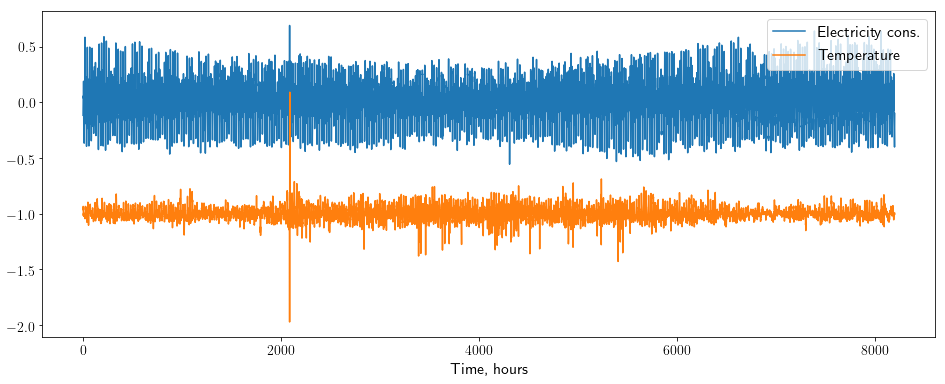

In [122]:
plt.figure(figsize=(16, 6))

plt.plot(X, label='Electricity cons.')
plt.plot(Y - 1, label='Temperature')

plt.xlabel('Time, hours', fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.legend(loc=1, fontsize=16)
plt.show()

In [123]:
left = 3000
right = 3400

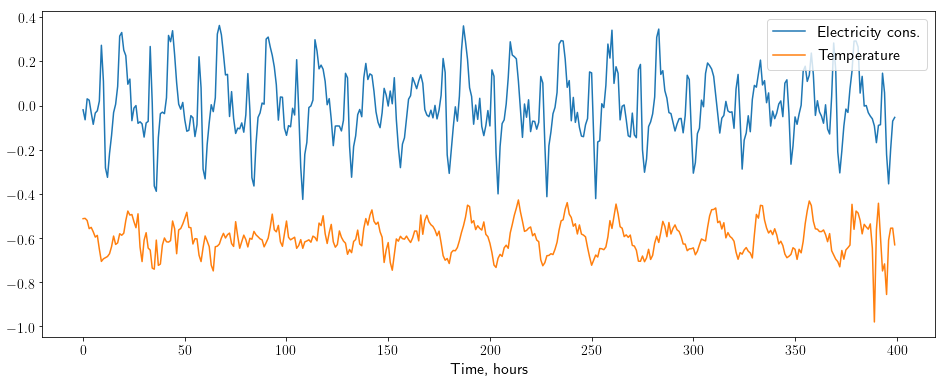

In [124]:
plt.figure(figsize=(16, 6))

plt.plot(X[left:right], label='Electricity cons.')
plt.plot(Y[left:right] - 0.6, label='Temperature')

plt.xlabel('Time, hours', fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.legend(loc=1, fontsize=16)
# plt.savefig('../slides/pictures/energy_temp/energy_temp_ts.eps', bbox_inches='tight')
plt.show()

### Связи рядов

In [24]:
# X_knn_idx, Y_knn_idx, Pr_x, Pr_y = CCM(X, Y, L=170, t_x=400, t_y=400, n_neighbors=19)
X_knn_idx, Pr_x = CCM(X, L=170, t=400, n_neighbors=19)
Y_knn_idx, Pr_y = CCM(Y, L=170, t=400, n_neighbors=19)

(8030, 8030) (170,) (170, 170)
(8030, 8030) (170,) (170, 170)


#### Зависимость Y от X, находим соседей по X

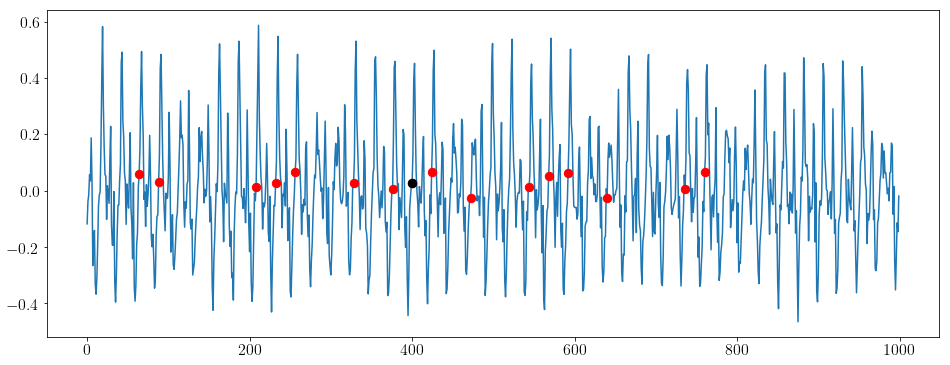

In [78]:
knn.PlotTsWithKnn(X, X_knn_idx, t_max=1000, savefig=False, 
              filename='../text/pictures/energy_temp/X_knn_L'+ str(L) + '.eps')

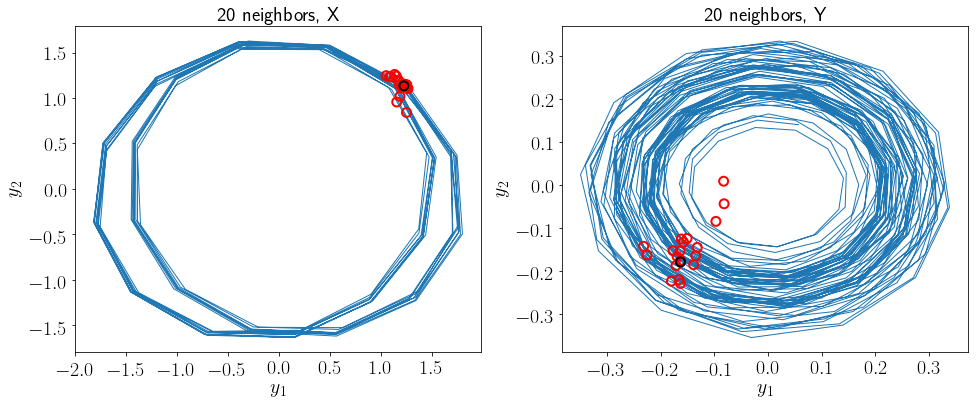

In [79]:
# было 'X', [0, 1], [200, 400] и Y -- [2, 3], [400, 1150]
knn.PlotKnnOnPhaseTrajectories([(Pr_x, X_knn_idx, 'X', [0, 1], [200, 400]),
                            (Pr_y, X_knn_idx, 'Y', [2, 3], [400, 1150])],
                           savefig=False,filename='../slides/pictures/energy_temp/by_X_L' + str(L) + '_12.eps', 
                           size=20, i_list=[0, 1, 6])

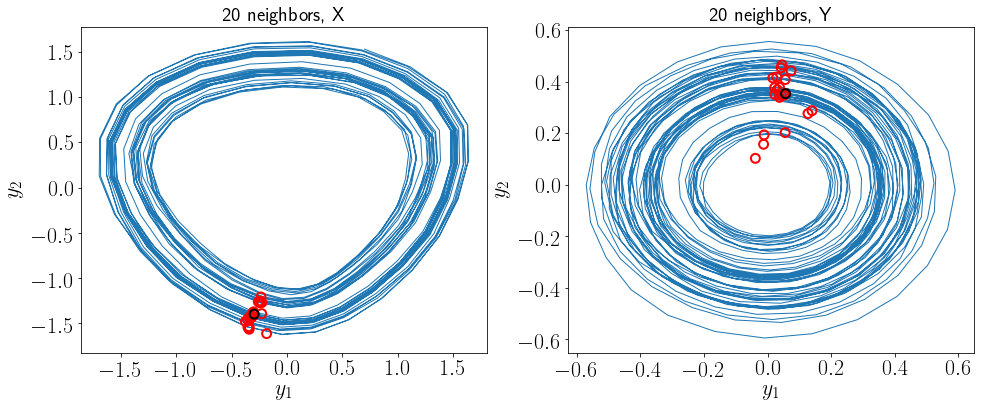

In [47]:
knn.PlotKnnOnPhaseTrajectories([(Pr_x, X_knn_idx, 'X', [2, 3], [100, 1000]),
                            (Pr_y, X_knn_idx, 'Y', [0, 1], [100, 1400])],
                           savefig=False, filename='../text/pictures/energy_temp/by_X_L' + str(L) + '_24.eps')

#### Зависимость X от Y, находим соседей по Y

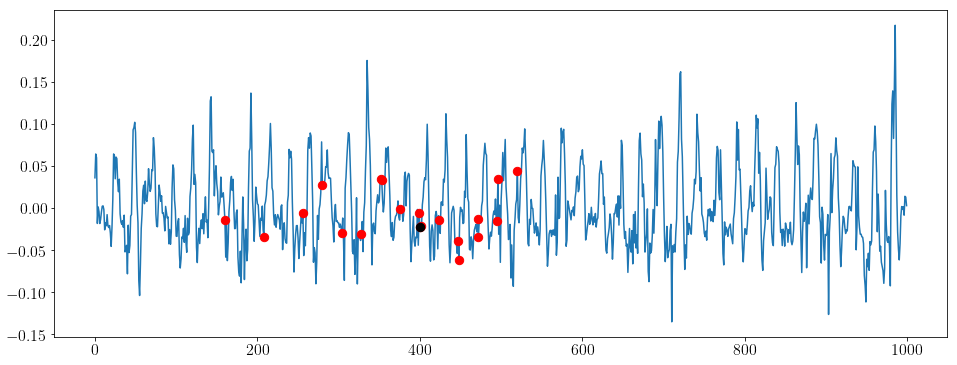

In [48]:
knn.PlotTsWithKnn(Y, Y_knn_idx, t_max=1000, savefig=False, 
              filename='../text/pictures/energy_temp/Y_knn_L'+ str(L) + '.eps')

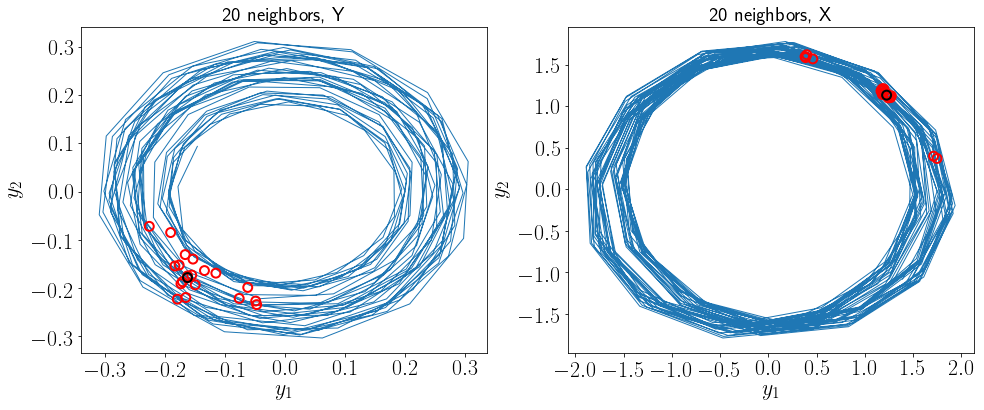

In [49]:
# 'Y', [2, 3], [6100, 6500], 'X', [0, 1], [6000, 6500]
knn.PlotKnnOnPhaseTrajectories([(Pr_y, Y_knn_idx, 'Y', [2, 3], [6100, 6500]), 
                            (Pr_x, Y_knn_idx, 'X', [0, 1], [6000, 6500])], 
                           savefig=False, filename='../slides/pictures/energy_temp/by_Y_L' + str(L) + '_12.eps',
                          i_list=[0, 3, 5])

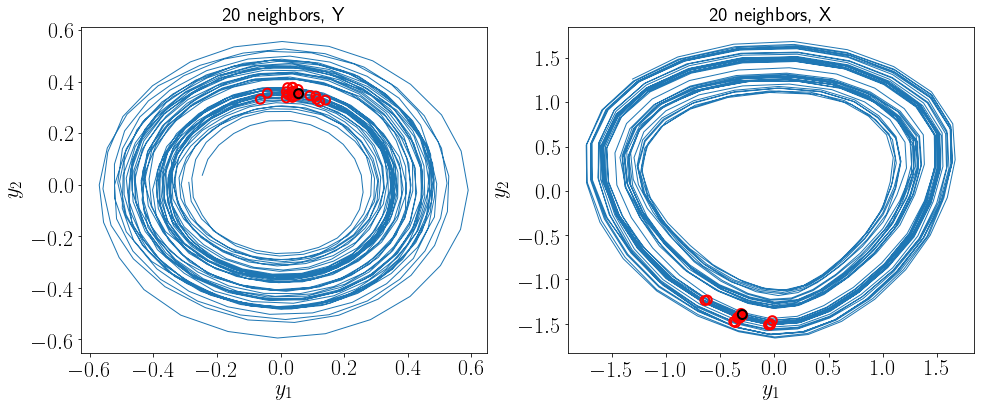

In [50]:
knn.PlotKnnOnPhaseTrajectories([(Pr_y, Y_knn_idx, 'Y', [0, 1], [0, 1150]), 
                            (Pr_x, Y_knn_idx, 'X', [2, 3], [0, 1000])], 
                           savefig=False, filename='../slides/pictures/energy_temp/by_Y_L' + str(L) + '_24.eps')

### S(x, y), график

In [25]:
def MeanDist(vectors):
    dist_list = [np.linalg.norm(vectors[0] - vec) for vec in vectors[1:]]
    return np.array(dist_list).mean()

In [26]:
N = X.shape[0]
L = 170

In [27]:
H_X = knn.HankelMatrix(X, L)
H_Y = knn.HankelMatrix(Y, L)

In [28]:
X_svd_data = knn.Svd(H_X, verbose=True)
Y_svd_data = knn.Svd(H_Y, verbose=True)

Pr_x = knn.Projection(*X_svd_data)
Pr_y = knn.Projection(*Y_svd_data)

del X_svd_data, Y_svd_data

[91.11393049 90.04725046 83.71879363 82.91058522 37.86564594]
[31.03344935 30.69053938 12.00980864 11.9154277   8.26738378]
(8030, 8030) (170,) (170, 170)
(8030, 8030) (170,) (170, 170)


In [29]:
import itertools

In [30]:
def StrFromList(l, delim=' '):
    res = ''
    for item in l:
        res += str(item) + delim
        
    return res

In [88]:
plot_X = np.zeros((31, 31))
plot_Y = np.zeros((31, 31))
comps = np.zeros((31, 31, 2))
comps = np.asarray(comps, dtype='<U32')

In [89]:
K = 5
x_idx = 0
y_idx = 0
comps_list = []

for k_x in range(1, K + 1):
    for comp_idx_x in itertools.combinations(range(0, K), k_x):
        y_idx = 0
        for k_y in range(1, K + 1):
            for comp_idx_y in itertools.combinations(range(0, K), k_y):
                comps_list.append((comp_idx_x, comp_idx_y))
                
                comps[x_idx][y_idx] = (StrFromList(comp_idx_x), StrFromList(comp_idx_y))
                
                X_knn_idx = knn.FindKnnIdx(Pr_x[:, list(comp_idx_x)], t=400, n_neighbors=19)
                plot_X[x_idx][y_idx] = MeanDist(Pr_x[X_knn_idx, :][:, list(comp_idx_x)]) /\
                                        MeanDist(Pr_y[X_knn_idx, :][:, list(comp_idx_y)])
                plot_X[x_idx][y_idx] *= float(len(comp_idx_y)) / len(comp_idx_x)
                
                Y_knn_idx = knn.FindKnnIdx(Pr_y[:, list(comp_idx_y)], t=400, n_neighbors=19)
                plot_Y[x_idx][y_idx] = MeanDist(Pr_y[Y_knn_idx, :][:, list(comp_idx_y)]) /\
                                       MeanDist(Pr_x[Y_knn_idx, :][:, list(comp_idx_x)])
                plot_Y[x_idx][y_idx] *= float(len(comp_idx_x)) / len(comp_idx_y)
                
                y_idx += 1
               
        x_idx += 1

In [33]:
ticks = []

for item in comps:
    key_x = StrFromList(item[0])
    key_y = StrFromList(item[1])
    """
    key_y = ''
    for idx in item[0]:
        key_x += str(idx) + ' '
    for idx in item[1]: 
        key_y += str(idx) + ' '"""
    ticks.append((key_x, key_y))
    
ticks = np.array(ticks)

In [90]:
plot_X = np.array(plot_X)
plot_Y = np.array(plot_Y)

In [98]:
sort = True

plot_X_sorted = plot_X.copy()
plot_Y_sorted = plot_Y.copy()

if sort:
    plot_X_sorted.sort(axis=0)
    plot_Y_sorted.sort(axis=1)
# comp_order = np.argsort(plot_X, axis=0)


In [92]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

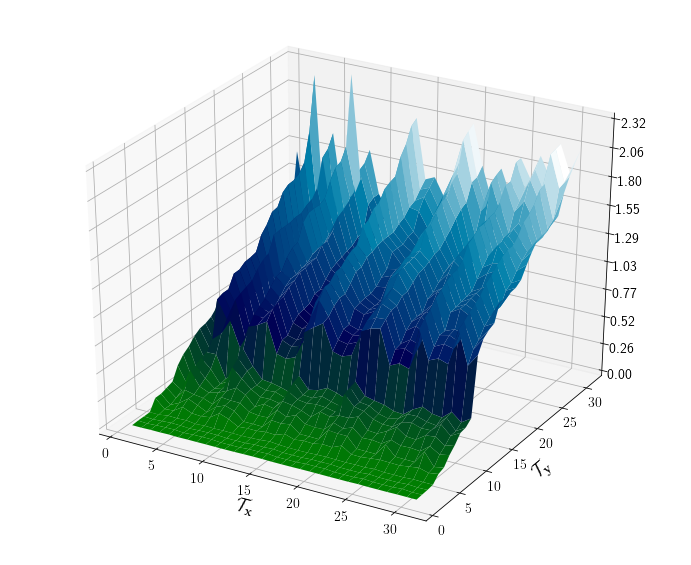

In [125]:
fig = plt.figure(figsize=(12, 10)) 
ax = fig.add_subplot(111, projection='3d')

x = range(1, 32)
y = range(1, 32)
x, y = np.meshgrid(x, y)
# Z = plot_X
Z = plot_X_sorted

# coolwarm_r, ocean, viridis_r, RdYlBu

surf = ax.plot_surface(x, y, Z, cmap='ocean')


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.set_xlabel('$\mathcal{T}_{\mathbf{x}}$', fontsize=18)
ax.set_ylabel('$\mathcal{T}_{\mathbf{y}}$', fontsize=18)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

# plt.savefig('../slides/pictures/energy_temp/3d_comps_by_X.eps', bbox_inches='tight')
plt.show()

In [94]:
x, y = np.unravel_index(np.argmax(plot_X), plot_X.shape)
argmax = np.argmax(plot_X)
argmax, x, y

(223, 7, 6)

In [95]:
comps_list[argmax]

((0, 3), (0, 2))

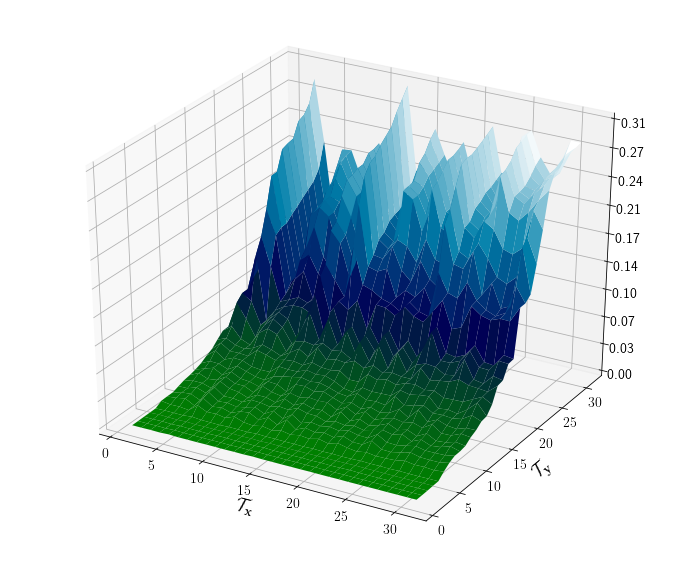

In [126]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

x = range(1, 32)
y = range(1, 32)
x, y = np.meshgrid(x, y)
# Z = plot_Y.T
Z = plot_Y_sorted.T

surf = ax.plot_surface(x, y, Z, cmap='ocean')


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel('$\mathcal{T}_{\mathbf{x}}$', fontsize=18)
ax.set_ylabel('$\mathcal{T}_{\mathbf{y}}$', fontsize=18)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.savefig('../slides/pictures/energy_temp/3d_comps_by_Y.eps', bbox_inches='tight')
plt.show()

In [101]:
x, y = np.unravel_index(np.argmax(plot_Y), plot_Y.shape)
argmax = np.argmax(plot_Y)
argmax, x, y

(389, 12, 17)

In [102]:
comps_list[argmax]

((2, 3), (0, 1, 4))

In [195]:
np.unravel_index(np.argmax(plot_X), plot_X.shape), np.unravel_index(np.argmax(plot_Y), plot_X.shape)

((30, 4), (2, 25))

### Прогноз рядов

In [127]:
all_data = pd.DataFrame({'X' : X, 'Y' : Y})
print(all_data.shape)
all_data.head()

(8199, 2)


,X,Y
0,-0.117743,0.035765
1,-0.037999,0.064133
2,-0.014819,0.059655
3,0.057215,-0.018626
4,0.034695,0.001065


In [129]:
import ssa
ssa = importlib.reload(ssa)

In [130]:
mssa_results = {}

In [131]:
r = 2
L = 100 

In [132]:
train_len = 3000
test_len = 100

first_train_bounds = (0, train_len)

In [133]:
def make_key(l, sep):
    return sep.join(l)

In [134]:
t1 = datetime.now()
forecast_X_stat, mean_error_X_stat = ssa.mean_forecast_error_for_n_points(mssa_results, r, L, 
                                                                          all_data, ['X'], 
                                                                          first_train_bounds, 
                                                                          test_len, 'X', make_key)


forecast_XY_stat, mean_error_XY_stat = ssa.mean_forecast_error_for_n_points(mssa_results, r, L, 
                                                                            all_data, ['X', 'Y'],
                                                                            first_train_bounds, 
                                                                            test_len, 'X', make_key)

dt = datetime.now() - t1
print(dt.seconds + dt.microseconds / 1e6)

16.07223


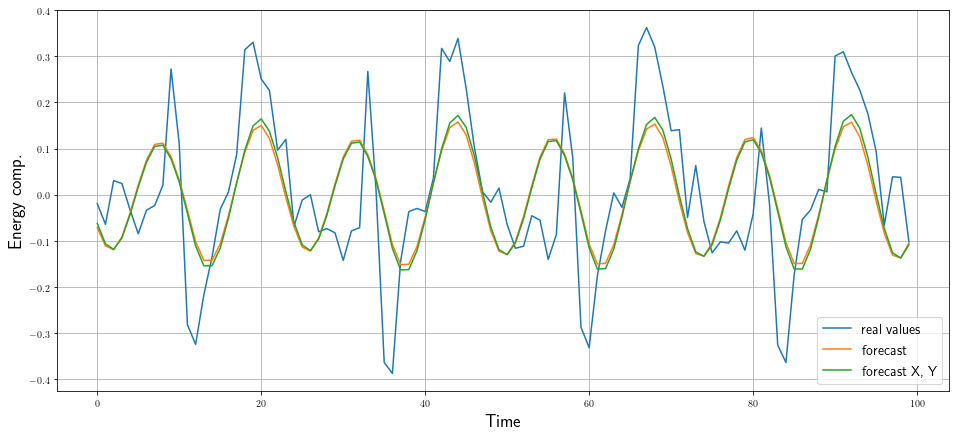

In [135]:
plt.figure(figsize=(16, 7))
plt.grid()

plt.plot(list(X[train_len : train_len + test_len][:300]), label='real values')
plt.plot(forecast_X_stat[:300], label='forecast')
plt.plot(forecast_XY_stat[:300], label='forecast X, Y')

plt.xlabel('Time', fontsize=18)
plt.ylabel('Energy comp.', fontsize=18)

plt.legend(fontsize=14)
# plt.savefig('forecast_example_6_140_XH.eps')
plt.show()

In [136]:
mean_error_X_stat, mean_error_XY_stat

(0.01921818096373799, 0.018084884349301143)

In [137]:
def run_mssa_compute_error(mssa_results, 
                           ts_pair, all_data, 
                           L_list, r_1, r_2,
                           make_key, comp_idx_list=None):
    
    for L in L_list:
        if (L % 50 == 0):
            print('L =', L)

        forecast_1, mean_error_1 = ssa.mean_forecast_error_for_n_points(mssa_results, r_1, L, 
                                                                        all_data, [ts_pair[0]], 
                                                                        first_train_bounds, test_len, 
                                                                        ts_pair[0], make_key)

        forecast_2, mean_error_2 = ssa.mean_forecast_error_for_n_points(mssa_results, r_2, L, 
                                                                        all_data, ts_pair, 
                                                                        first_train_bounds, test_len, 
                                                                        ts_pair[0], make_key, comp_idx_list)

        if comp_idx_list is None:
            comp_key = 'all'
        else:
            comp_key = ', '.join(map(lambda x: str(x), comp_idx_list))

        key_1 = ts_pair[0]
        key_2 = make_key(ts_pair, ', ') + ', ' + comp_key
        
        if key_1 not in mean_errors:
            mean_errors[key_1] = {}

        if key_2 not in mean_errors:
            mean_errors[key_2] = {}

            
        mean_errors[key_1][L] = mean_error_1
        mean_errors[key_2][L] = mean_error_2

        if key_1 not in error_statistic:
            error_statistic[key_1] = []

        error_statistic[key_1].extend(list(forecast_1 - all_data[key_1][-test_len:]))

In [138]:
ssa = importlib.reload(ssa)

In [139]:
error_statistic = {}
mean_errors = {}

In [140]:
mssa_results = {}

In [141]:
ts_pairs = [['X', 'Y']]

In [142]:
train_len = 1000
test_len = 100

first_train_bounds = (0, train_len)

In [158]:
for ts_pair in ts_pairs:
    for comp_idx_list in [None, [0, 1], [2, 3], [0, 1, 2, 3]]:
        key = make_key(ts_pair, ', ') + ', ' 
        if comp_idx_list is not None:
            key += make_key(map(lambda x: str(x), comp_idx_list), ', ')
        else:
            key += 'all'
            
        print(key)

X, Y, all
X, Y, 0, 1
X, Y, 2, 3
X, Y, 0, 1, 2, 3


In [159]:
L_list = [20 * x for x in range(3, 18)]


for ts_pair in ts_pairs:
    for comp_idx_list in [None, [0, 1], [0, 2], [2, 3], [0, 1, 2, 3]]:
        key = make_key(ts_pair, ', ') + ', ' 
        if comp_idx_list is not None:
            key += make_key(map(lambda x: str(x), comp_idx_list), ', ')
        else:
            key += 'all'
        if key not in mean_errors:
            mssa_results = {}
            # print('pair:', ts_pair, 'r_1 =', r_1, 'r_2 =', r_2)
            run_mssa_compute_error(mssa_results, ts_pair, all_data, L_list, 5, 10, make_key, comp_idx_list)

L = 100
L = 200
L = 300


In [160]:
def make_label(names_list):
    first_letters = []
    
    for name in names_list:
        first_letters.append(name)
        
    return ', '.join(first_letters)

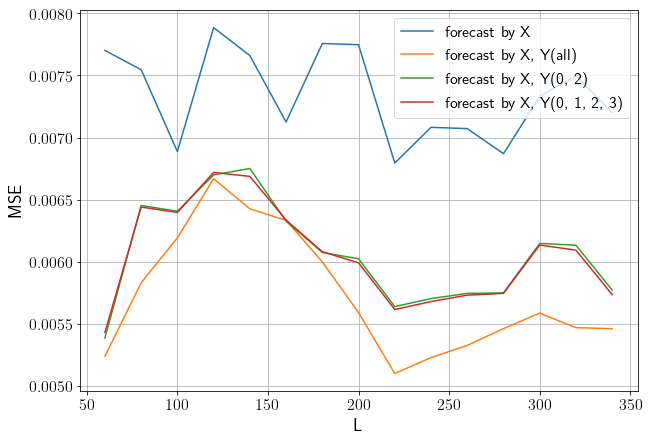

In [172]:
for ts_pair in ts_pairs:
    plt.figure(figsize=(10, 7))
    
    key_1 = ts_pair[0]
    key_2 = make_key(ts_pair, ', ')
    key_to_save = make_key(ts_pair, '')

    label_1 = 'forecast by ' + make_label([ts_pair[0]])
    label_2 = 'forecast by ' + make_label(ts_pair)
    
    plt.plot(mean_errors[key_1].keys(), mean_errors[key_1].values(), label=label_1)
    
    for comp_idx_list in ['all', '0, 2', '0, 1, 2, 3']:
        new_key_2 = key_2 + ', ' + comp_idx_list
        if new_key_2 in mean_errors:
            plt.plot(mean_errors[new_key_2].keys(), mean_errors[new_key_2].values(), 
                     label=label_2 + '({})'.format(comp_idx_list))
    
    plt.xlabel('L', fontsize=18)
    plt.ylabel('MSE', fontsize=18)
    

    # plt.tick_params(axis='x', labelsize=13)
    # plt.tick_params(axis='y', labelsize=13)
    plt.xticks(size=16)
    plt.yticks(size=16)
    
    title_label_1 = make_label([ts_pair[0]])
    title_label_2 = make_label(ts_pair)
    
    plt.grid()
    # plt.title(title_label_1 + ' vs. ' + title_label_2, fontsize=20)
    plt.legend(fontsize=16, loc=1)
    # plt.savefig('../slides/pictures/energy_temp/forecast_error_diff_Y_comps_5_10.eps', bbox_inches='tight')
    plt.show()

In [149]:
mean_errors.keys()

dict_keys(['X', 'X, Y, all', 'X, Y, 0, 1', 'X, Y, 2, 3', 'X, Y, 0, 1, 2, 3'])

In [152]:
mean_errors['X, Y, 0, 1']

{20: 0.0117864836973706,
 40: 0.007900218329293388,
 60: 0.00841118210331325,
 80: 0.009095984403858117,
 100: 0.00888997065674882,
 120: 0.009293022668167374,
 140: 0.0090201395532858,
 160: 0.009040512048822771,
 180: 0.009223606457131337,
 200: 0.008895860370814973}

In [153]:
mean_errors['X, Y, 2, 3']

{20: 0.011786483697370611,
 40: 0.007900218329293397,
 60: 0.00841118210331325,
 80: 0.009095984403858113,
 100: 0.008889970656748817,
 120: 0.009293022668167368,
 140: 0.009020139553285806,
 160: 0.009040512048822768,
 180: 0.009223606457131342,
 200: 0.00889586037081497}

r1=2, r2=4